# <font color=Crimson size=6 face="宋体" align="center">k均值聚类算法（k-means clustering algorithm）</font>     
--------------

kmeans算法是无监督的聚类算法

以二维模拟样本为例，使用Kmeans算法聚类

In [20]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import ipywidgets as widgets
import pylab
import os

from dataset_producer import Dataset,rand_data

FIG_SIZE=(10,6)

## 导入原始数据(import the dataset)
TODO:
添加样本点更多、数据分布不同的数据集

In [21]:
#数据集存放位置
DATA_DIR="testdata/"
all_data_path=[]
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        all_data_path.append(os.path.join(root,file))
        
#可交互文件选择模块
iw_filename=widgets.Dropdown(
    options=all_data_path,
    description='选择原有数据集（生成的数据集为tempset.txt）:',
    disabled=False,
    
)

w_gen_button=widgets.Button(
    description='生成随机数据集',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon=''
)

w_output=widgets.Output()

w_rand_size=widgets.IntSlider(
    value=100,
    min=10,
    max=10000,
    continuous_update=False,
    description='生成数据个数'
)

def gen_rand_data(b):
    """
    点击按钮生成随机数据集，写入testdata，并展示
    :param b:无意义
    :return:
    """
    new_dataset=rand_data(n=w_rand_size.value,d=2)
    new_dataset.path='testdata/tempset.txt'
    new_dataset.write_data()
    with w_output:
        w_output.clear_output()
        new_dataset.show_data()

def choose_show(change):
    """
    选择原有数据集，展示原始数据
    :param b: 无意义
    :return:
    """
    new_dataset=Dataset(path=change['new'])
    with w_output:
        w_output.clear_output()
        new_dataset.show_data()

iw_filename.observe(choose_show,names='value')
w_gen_button.on_click(gen_rand_data)
display(w_rand_size,w_gen_button,iw_filename,w_output)
# interact(show_base_data,filename=iw_filename)

IntSlider(value=100, continuous_update=False, description='生成数据个数', max=10000, min=10)

Button(description='生成随机数据集', style=ButtonStyle(), tooltip='Click me')

Dropdown(description='选择原有数据集（生成的数据集为tempset.txt）:', options=('testdata/randset.txt', 'testdata/tempset.txt', …

Output()

## 探索数据(explore the data)

In [22]:
"""
对于给定数据集进行相关处理并展示
"""
w_draw_output=widgets.Output()

def choose_draw(change):
    """
    数据集选择流程
    用户通过下拉菜单选择数据集
    进行相关处理并展示
    :param filename:widget传入的文件名
    """
    filename=change['new']
    pylab.rcParams['figure.figsize'] = FIG_SIZE
    new_dataset=Dataset(path=filename)
    with w_draw_output:
        w_draw_output.clear_output()
        new_dataset.draw_data()

iw_filename.observe(choose_draw,names='value')
display(iw_filename,w_draw_output)
# ow_data_shape=widgets.Output().append_stdout("该数据集有%d个%d维数据"%(np_data.shape[0],np_data.shape[1]))
# ow_draw_data=widgets.interactive_output(choose,{'filename':iw_filename})
# widgets.HBox([widgets.VBox([filename_widget,ow_data_shape,ow_draw_data]),ow_base_data])
# interact(choose_draw,filename=iw_filename)

Dropdown(description='选择原有数据集（生成的数据集为tempset.txt）:', options=('testdata/randset.txt', 'testdata/tempset.txt', …

Output()

Kmeans算法

初始化聚类中心

TODO:
1.更新K值全部初始化中心点
2.按钮添加一个随机中心点
3.输入坐标添加中心点

In [23]:
def plot_data(x,idx,K,cent,centroids,cnt):
    m=x.shape[0]
    tmp_idx=[]
    color_list=['r','g','y','b','m','orange']
    tmp_idx=idx[:,0].tolist() #要把numpyfloat64转换为list int
    for i in range(m):
        plt.scatter(x[i,0],x[i,1],marker='x',color=color_list[int(tmp_idx[i])])

   # plt.scatter(centroids[:,0],centroids[:,1],marker='o',color = 'black',linewidths=10)

    for k in range(K):
        plt.scatter(centroids[k,0],centroids[k,1],marker='o',color = color_list[k],linewidths=10)
        plt.plot(np.array(cent["%d"%(k)])[:,0],np.array(cent["%d"%(k)])[:,1],"b-o",color=color_list[k])
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title("figure %d"%(cnt))
    plt.subplots_adjust(wspace=0)
    plt.savefig("figure %d.jpg"%(cnt),dpi=300)
    plt.show()

def randCentroids(x:np.array,k:int)->np.array:
    """
    随机初始化centroids ,随机选择k个样本点作为质心
    :param x:numpy_data
    :param k:随机选取k个
    :return:选取的中心点
    """
    m,n = x.shape # m=80个数据，n=2维
    centroids = np.zeros((k,n)) #产生k个 [0 0]的数据
    randIndex = np.random.choice(m,k) #从m个数据中选k个randindex
    centroids = x[randIndex]
    return centroids

#可交互K值选择
# K_widget=widgets.IntSlider(value=4,min=1, max=6, step=1, continuous_update=False)
# interact(randCentroids,k=K_widget)

In [24]:
#计算距离
def computeDistance(A,B):
    return np.sqrt(np.sum(np.square(A-B)))

#计算x的均值，改变centroids
def change_centroids(x,idx,K):
    m,n = x.shape
    centroids = np.zeros((K,n))
    for i in range(K):
        index = np.where(idx[:,0].ravel() == i)
        centroids[i] = np.mean(x[index],axis=0)
    return centroids

#为数据集x找到最近的质心,直到质心不变为止   
def kmeans(x,K):
    #1.初始化质心
    centroids = randCentroids(x,K)
    m = x.shape[0]
    idx = np.zeros((x.shape[0],2)) #记录x对应的质心的下标 + 平方误差
    clusterchanged = True #记录分类是否变化
    cent = {} #用字典，来存储各个质心的变化
    cnt=0 #记录分配点的次数
    
    # 初始化质心字典
    for k in range(K):
        cent["%d"%(k)] = []
        cent["%d"%(k)].append(centroids[k,:].tolist())
        
    while clusterchanged:
        
        clusterchanged = False
        #2.为每个样本点分配质心
        for i in range(m):
            minDist = np.inf
            minIndex = -1
            for j in range(K):
                distance = computeDistance(x[i,:],centroids[j,:])
                if distance<minDist:
                    minDist = distance
                    minIndex = j
            if idx[i,0] != minIndex:
                clusterchanged = True
            idx[i,:] = minIndex, minDist**2
        #分配完点之后的情况输出一下
        cnt=cnt+1
        plot_data(x,idx,K,cent,centroids,cnt)
        #3.更新质心的位置
        centroids = change_centroids(x,idx,K)
        # 4.更新质心字典
        for k in range(K):
            cent["%d"%(k)].append(centroids[k,:].tolist())
    plot_data(x,idx,K,cent,centroids,cnt)
    
    return centroids,idx,cent,cnt



IntSlider(value=4, continuous_update=False, max=6, min=1)

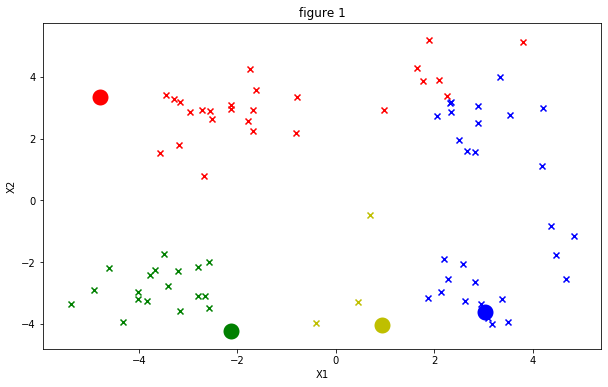

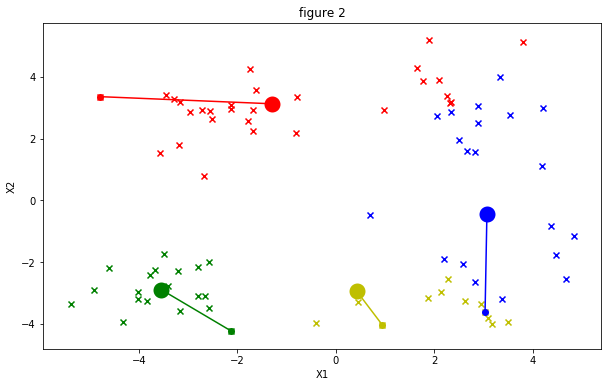

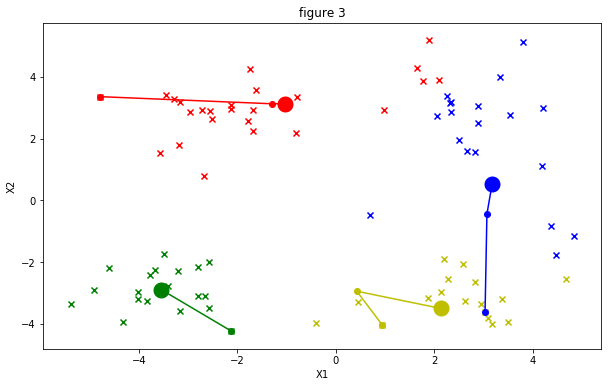

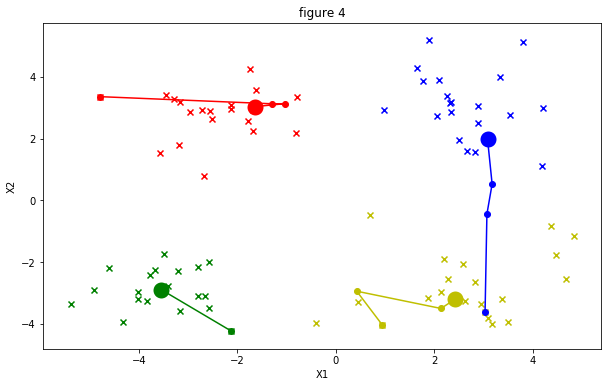

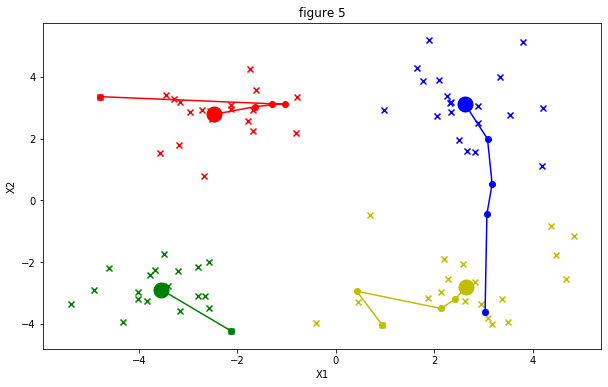

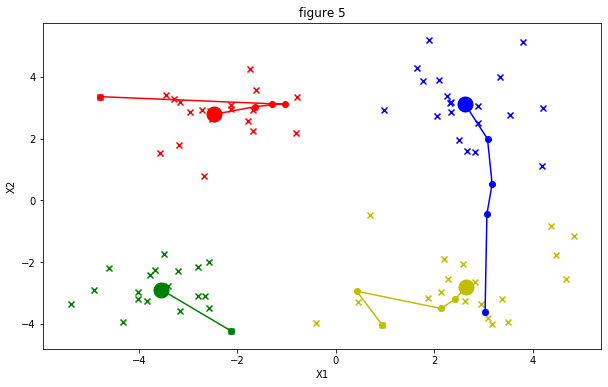

In [25]:
new_data_set=Dataset(path=iw_filename.value)
K_widget=widgets.IntSlider(value=4,min=1, max=6, step=1, continuous_update=False)
display(K_widget)
pylab.rcParams['figure.figsize'] = FIG_SIZE
centroids,idx,cent,cnt = kmeans(new_data_set.data,K_widget.value)

In [26]:

def choose_display(n):
    pylab.rcParams['figure.figsize'] = FIG_SIZE
    a=plt.imread("figure %d.jpg"%(n))
    plt.axis("off")
    plt.imshow(a)

n_widget=widgets.IntSlider(min=1,max=cnt,description='迭代次数')
play_widget = widgets.Play(
    interval=2000,
    value=1,
    min=1,
    max=cnt,
    step=1,
    description="Press play",
    disabled=False
)

widgets.jslink((play_widget, 'value'), (n_widget, 'value'))
out = widgets.interactive_output(choose_display, {'n': n_widget})
out.
# widgets.VBox([widgets.HBox([play_widget,n_widget]), out])
display(play_widget,n_widget,out)

SyntaxError: invalid syntax (<ipython-input-26-63b40e528d93>, line 20)

Kmeans算法的局限性

TODO:
1.依赖初始聚类中心
2.K值的选择
3.适用的数据类型